In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    document.body.style.fontFamily='Palatino';
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

## 7.3.6 Exercices
### Exercice 6.
Soit la fonction de boucle ouverte d'un processus: $$G(p)={\frac {1}{p(1+0,1p)(1+p)}}$$

On demande de déterminer *graphiquement* le correcteur PD de manière à optimiser le temps de réponse du système, à garantir une erreur de vitesse de 10% et une marge de phase de 45°.

#### Solution:

Fixer l'erreur de vitesse à 10% impose le gain: $\varepsilon_v={\frac{1}{K_P}}=0.1$ d'où $K_P=10$.

Pour choisir la constante de temps de dérivation, nous avons deux possibilités:

In [2]:
from IPython.display import display, Markdown

from control.matlab import *  # Python Control Systems Toolbox (compatibility with MATLAB)
import numpy as np              # Library to manipulate array and matrix
import matplotlib.pyplot as plt # Library to create figures and plots
import math # Library to be able to do some mathematical operations
import ReguLabFct as rlf # Library useful for the laboratory of regulation of Gramme

In [3]:
# Fonction de transfert en boucle ouverte
G1 = tf(1, [1, 0])
G2 = tf(1, [0.1, 1])
G3 = tf(1, [1, 1])
G = G1*G2*G3  # G de l'énoncé 

MP = 45 # Marge de phase réclamée
Kp = 10

##### $1^{ère}$ méthode: suppression du pôle dominant

$\tau_d=1$ et nous vérifions les performances obtenues pour le système corrigé.

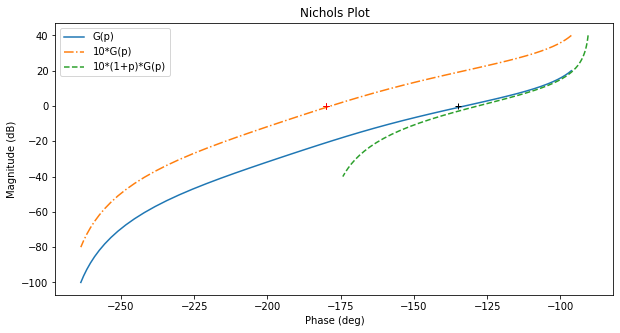

In [4]:
tD = 1
Corr = Kp*tf([tD, 1],1)

fig = plt.figure("Nichols",figsize=(10,5))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['10*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['10*(1+p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')

ax.plot(-180+MP, 0,'k+'); # ; pour supprimer les lignes de sortie matplotlib

Les performances du système ainsi corrigé sont :


Système non corrigé
-------------------
Marge de phase = 47.404°
DC gain = 0.999
Rise Time = 1.561 s
Peak amplitude = 1.206
Overshoot = 20.712%
Settling Time = 5.383 s


Système corrigé
---------------
Marge de phase = 51.827°
DC gain = 1.000
Rise Time = 0.164 s
Peak amplitude = 1.163
Overshoot = 16.303%
Settling Time = 0.528 s



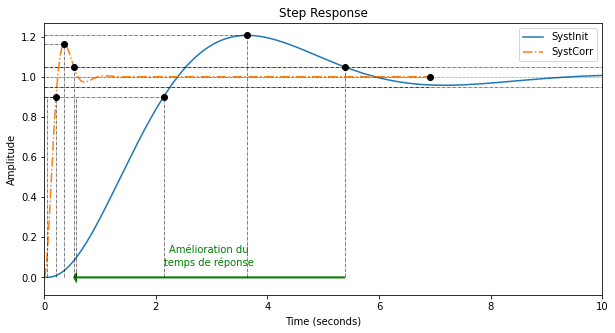

In [5]:
fig = plt.figure("Step Response",figsize=(10,5))
ax = fig.subplots()

# Système non corrigé
# -------------------

Gbf = feedback(G,1)
info = rlf.info()
rlf.stepWithInfo(Gbf, info, NameOfFigure="Step Response", sysName='SystInit') # Renvoie toutes les infos du step

ep = (1-info.DCGain)*100 # Erreur de position

gm, pm, wg, wp = margin(G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème non corrigé")
print("-------------------")
print(f"""Marge de phase = {pm:.3f}°
DC gain = {info.DCGain:.3f}
Rise Time = {info.RiseTime:.3f} s
Peak amplitude = {info.Peak:.3f}
Overshoot = {info.Overshoot:.3f}%
Settling Time = {info.SettlingTime:.3f} s
""")

# Système corrigé
# ---------------
Gbf_PD = feedback(Corr*G,1)
info_PD = rlf.info()
rlf.stepWithInfo(Gbf_PD, info_PD, NameOfFigure="Step Response", sysName='SystCorr', linestyle='-.') # Renvoie toutes les infos du step

ep_PD = (1-info_PD.DCGain)*100 # Erreur de position

gm, pm, wg, wp = margin(Corr*G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème corrigé")
print("---------------")
print(f"""Marge de phase = {pm:.3f}°
DC gain = {info_PD.DCGain:.3f}
Rise Time = {info_PD.RiseTime:.3f} s
Peak amplitude = {info_PD.Peak:.3f}
Overshoot = {info_PD.Overshoot:.3f}%
Settling Time = {info_PD.SettlingTime:.3f} s
""")

# Ajout de détails
ax.set_xlim(0, 10); # Zoom sur la région d'intérêt

ax.arrow(info.SettlingTime, 0, -(info.SettlingTime-info_PD.SettlingTime), 0, 
         length_includes_head=True, width=.005, head_width=0.05, head_length=0.05, color='g');

ax.text(info.SettlingTime-(info.SettlingTime-info_PD.SettlingTime)/2, 0.05, 'Amélioration du\ntemps de réponse', verticalalignment='bottom', 
        horizontalalignment='center', color='g');

##### $2^{ème}$ méthode: placement fréquentiel

$K_P$ étant fixé, traçons $K_P*G(p)$ : le système est instable et nous allons nous efforcer de le
stabiliser par l’intermédiaire du terme $(1+\tau_D*p)$.

Ce terme a pour effet, pour la pulsation $\omega=\frac{10}{\tau_D}$, de translater le module de +20 dB et
d’introduire un déphasage de +90° (+84° pour être précis).

Comme nous voulons que le système en trait mixte soit corrigé et passe par le point
(0dB,-135°), cherchons le point qui a une phase de –135°-84° ; son module vaut -23 dB. Il
sera donc corrigé par le terme $(1+\tau_D*p)$ et passera *approximativement* par le point voulu
(0dB,-135°).

Sur la courbe en trait interrompu, le point (–23dB,–135°-84°) correspond à une pulsation de
9.9rad/s, soit : $\tau_D=\frac{10}{\omega_{à -135°-84°}}=\frac{10}{9.9}=1.01s$.

Gain à -219° = -42.869391796777016 dB
Fréquence à -219° = 9.91515778991914 rad/sec


$\tau_D$=1.01

$C(p)*G(p) = 10*\frac{(1+1.01p)}{p(1+0.1p)(1+p)}$

Le système ainsi corrigé présente une marge de phase de 51.72° et une marge de gain de inf dB.


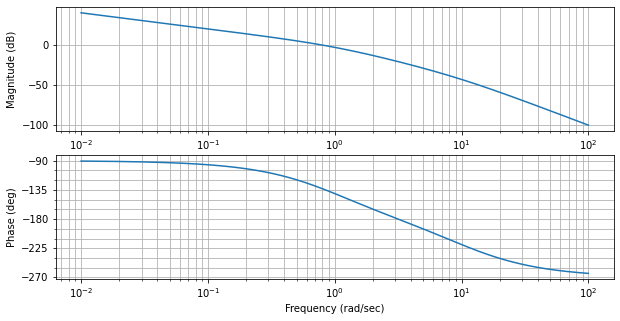

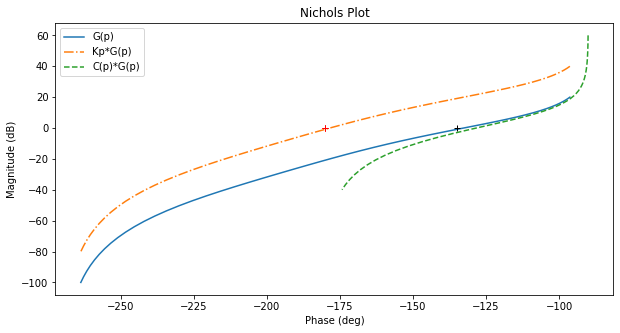

In [6]:
# Lecture phase
fig = plt.figure("Bode",figsize=(10,5))
ax = fig.subplots()
mag, w = rlf.getValues(G, -180+MP-84, printValue=True, NameOfFigure="Bode")

# tD
tD = 10/w # = tD conseillé
display(Markdown(rf"$\tau_D$={tD:.2f}"))
Corr = Kp*tf([tD, 1],1)
display(Markdown(r'$C(p)*G(p) = 10*\frac{(1+1.01p)}{p(1+0.1p)(1+p)}$'))

fig = plt.figure("Nichols",figsize=(10,5))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['Kp*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['C(p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')

ax.plot(-180+MP, 0,'k+'); # Ajout du repère (+) par lequel on est censé passer

gm, pm, wg, wp = margin(Corr*G) # Extrait la marge de gain (Gm) et de phase (Pm)
print(f"Le système ainsi corrigé présente une marge de phase de {pm:.2f}° et une marge de gain de {gm:.2f} dB.")


La marge de phase étant malgré tout toujours trop grande, par essai et erreur, nous allons augmenter $\tau_D$.

$\tau_D$=1.51

$C_2(p)*G(p) = 10*\frac{(1+1.51p)}{p(1+0.1p)(1+p)}$

Le système ainsi corrigé présente une marge de phase de 45.62° et une marge de gain de inf dB.


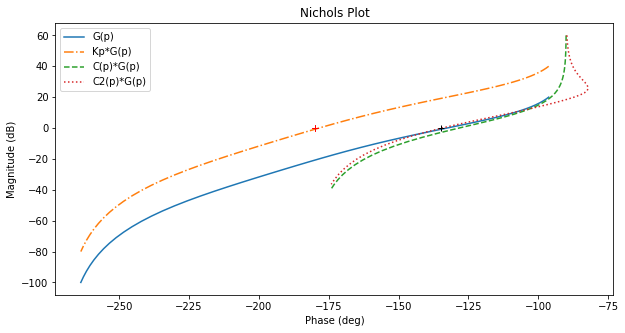

In [7]:
tD = 15/w # tD trouvé par essais-erreurs
display(Markdown(rf"$\tau_D$={tD:.2f}"))
Corr2 = Kp*tf([tD, 1],1)
display(Markdown(r'$C_2(p)*G(p) = 10*\frac{(1+1.51p)}{p(1+0.1p)(1+p)}$'))

fig = plt.figure("Nichols",figsize=(10,5))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['Kp*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['C(p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')
rlf.nichols(Corr2*G, grid = False, labels=['C2(p)*G(p)'], NameOfFigure = "Nichols", linestyle = ':')

ax.plot(-180+MP, 0,'k+'); # Ajout du repère (+) par lequel on est censé passer

gm, pm, wg, wp = margin(Corr2*G) # Extrait la marge de gain (Gm) et de phase (Pm)
print(f"Le système ainsi corrigé présente une marge de phase de {pm:.2f}° et une marge de gain de {gm:.2f} dB.")

Les performances du système ainsi corrigé sont :


Système non corrigé
-------------------
Marge de phase = 47.404°
DC gain = 0.999
Rise Time = 1.561 s
Peak amplitude = 1.206
Overshoot = 20.712%
Settling Time = 5.383 s


Système corrigé
---------------
Marge de phase = 45.620°
DC gain = 1.000 => Erreur de position = 0.002%
Rise Time = 0.123 s
Peak amplitude = 1.213
Overshoot = 21.340%
Settling Time = 0.636 s



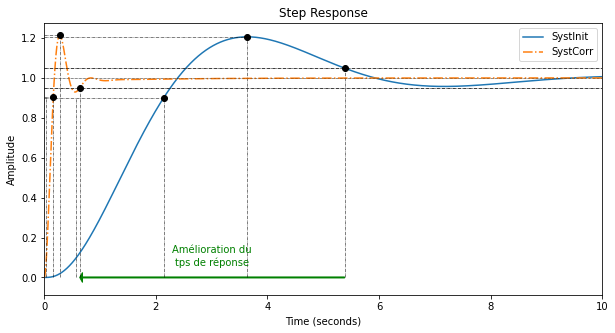

In [8]:
fig = plt.figure("Step Response",figsize=(10,5))
ax = fig.subplots()

# Système non corrigé
# -------------------

Gbf = feedback(G,1)
info = rlf.info()
rlf.stepWithInfo(Gbf, info, NameOfFigure="Step Response", sysName='SystInit') # Renvoie toutes les infos du step

ep = (1-info.DCGain)*100 # Erreur de position

gm, pm, wg, wp = margin(G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème non corrigé")
print("-------------------")
print(f"""Marge de phase = {pm:.3f}°
DC gain = {info.DCGain:.3f}
Rise Time = {info.RiseTime:.3f} s
Peak amplitude = {info.Peak:.3f}
Overshoot = {info.Overshoot:.3f}%
Settling Time = {info.SettlingTime:.3f} s
""")

# Système corrigé
# ---------------
Gbf_PD = feedback(Corr2*G,1)
info_PD = rlf.info()
rlf.stepWithInfo(Gbf_PD, info_PD, NameOfFigure="Step Response", sysName='SystCorr', linestyle='-.') # Renvoie toutes les infos du step

ep_PD = (1-info_PD.DCGain)*100 # Erreur de position

gm, pm, wg, wp = margin(Corr2*G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème corrigé")
print("---------------")
print(f"""Marge de phase = {pm:.3f}°
DC gain = {info_PD.DCGain:.3f} => Erreur de position = {ep_PD:.3f}%
Rise Time = {info_PD.RiseTime:.3f} s
Peak amplitude = {info_PD.Peak:.3f}
Overshoot = {info_PD.Overshoot:.3f}%
Settling Time = {info_PD.SettlingTime:.3f} s
""")

# Ajout de détails
ax.set_xlim(0, 10); # Zoom sur la région d'intérêt

ax.arrow(info.SettlingTime, 0, -(info.SettlingTime-info_PD.SettlingTime), 0, 
         length_includes_head=True, width=.005, head_width=0.05, head_length=0.05, color='g');

ax.text(info.SettlingTime-(info.SettlingTime-info_PD.SettlingTime)/2, 0.05, 'Amélioration du\ntps de réponse', verticalalignment='bottom', 
        horizontalalignment='center', color='g');

L'erreur de vitesse du système original vaut 100.0% et celle du système corrigé vaut 10.0%.

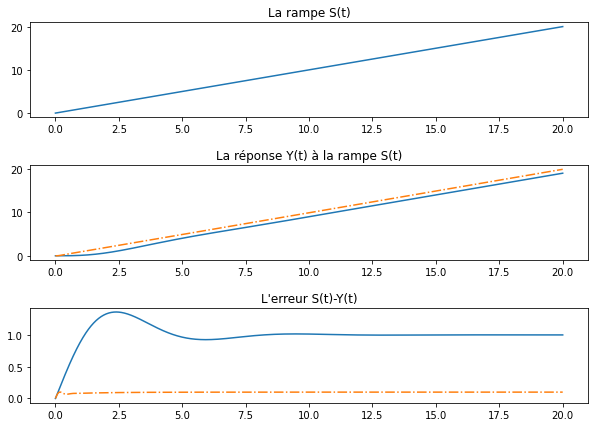

In [9]:
import warnings # Pour gérer les warnings

# Mesure de l'erreur de vitesse
t = linspace(0, 20, 1000)
s = t;
warnings.filterwarnings('ignore') # Pour désactiver les warnings inutiles
[y, t, xout] = lsim(Gbf,s,t) # Simuler la réponse à une rampe => erreur de vitesse
[y2, t, xout2] = lsim(Gbf_PD,s,t) # Simuler la réponse à une rampe => erreur de vitesse
warnings.filterwarnings('default') # Pour réactiver les warnings

plt.figure("Erreur de vitesse",figsize=(10,7))
plt.subplot(3,1,1); plt.plot(t,s); plt.title("La rampe S(t)")
plt.subplot(3,1,2); plt.plot(t,y); plt.plot(t, y2, linestyle='-.'); plt.title("La réponse Y(t) à la rampe S(t)")
plt.subplot(3,1,3); plt.plot(t,(s-y)); plt.plot(t, (s-y2), linestyle='-.'); plt.title("L'erreur S(t)-Y(t)")
plt.subplots_adjust(hspace=0.5) # Pour laisser un peu d'espace pour les titres

ev = s[-1] - y[-1] # Erreur de vitesse système original
ev2 = s[-1] - y2[-1] # Erreur de vitesse du système corrigé

display(Markdown(rf"L'erreur de vitesse du système original vaut {ev*100:.1f}% et celle du système corrigé vaut {ev2*100:.1f}%."))

In [10]:
HTML('''<script>initialize();</script>Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.''')